#Librerias

In [1]:
!pip install opencv-python # Instala la librería OpenCV para procesamiento de imágenes
!pip install keras-tuner # Se utiliza para realizar búsqueda automática de hiperparámetros en modelos Keras/TensorFlow.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [2]:
# Librerías del sistema y manejo de archivos
import os
import sys
from os import listdir
from os.path import join

# Librerías para uso en Google Colab
from google.colab import drive

# Librerías para procesamiento numérico y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

# Librerías para procesamiento y lectura de imágenes
import cv2

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import keras_tuner as kt

# Librerías para deep learning
import tensorflow as tf
from tensorflow.keras.metrics import Recall, AUC

# Librerías para utilidades adicionales
from tqdm import tqdm  # barra de progreso
import joblib  # para guardar/cargar objetos como modelos o arrays


# Conectar con google drive

In [3]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

# Carga de datos procesados

array([[[244, 164, 175],
        [241, 161, 172],
        [243, 162, 171],
        ...,
        [245, 165, 178],
        [241, 163, 176],
        [238, 160, 173]],

       [[244, 163, 171],
        [242, 161, 169],
        [242, 160, 170],
        ...,
        [243, 163, 176],
        [241, 161, 174],
        [238, 158, 171]],

       [[238, 156, 162],
        [239, 158, 164],
        [240, 159, 166],
        ...,
        [242, 162, 175],
        [240, 160, 173],
        [239, 159, 172]],

       ...,

       [[225, 155, 147],
        [226, 155, 148],
        [229, 158, 152],
        ...,
        [223, 150, 157],
        [226, 155, 161],
        [225, 154, 160]],

       [[224, 156, 147],
        [227, 159, 150],
        [228, 159, 152],
        ...,
        [223, 151, 155],
        [227, 156, 160],
        [227, 156, 159]],

       [[226, 158, 149],
        [226, 158, 150],
        [227, 158, 151],
        ...,
        [225, 153, 157],
        [225, 154, 158],
        [223, 152, 156]]], dtype=uint8)
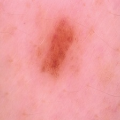

In [5]:
# Cargar los conjuntos de entrenamiento y prueba ya procesados

x_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_test.pkl')

x_train[0] # Muestra la primera imagen del conjunto de entrenamiento

## Preprocesamiento de datos

In [6]:
# Convertir a tipo float para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [7]:
x_train.max() # Ver valor máximo
x_train.min() # Ver valor mínimo

0.0

In [8]:
# Escalar valores entre 0 y 1 con base en el valor máximo
x_train /= 255
x_test  /= 255

## Cargar el modelo entrenado

In [9]:
modelo = tf.keras.models.load_model('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/skin_cancer_model.h5')  # Carga del mejor modelo entrenado

# Análisis del modelo

## Visualización de probabilidades (Test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step


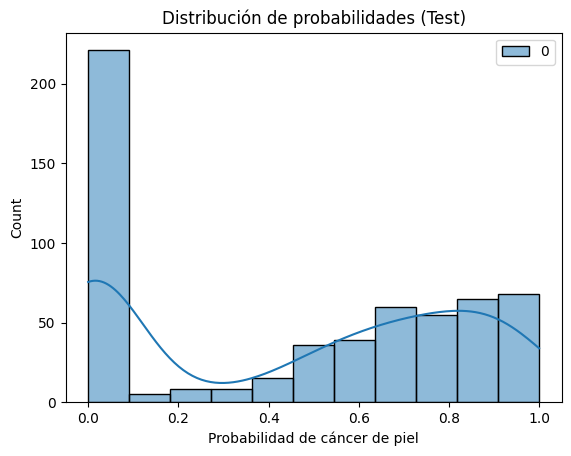

In [10]:
prob_test = modelo.predict(x_test)  # para las probabilidades predichas por el modelo en cada imagen del conjunto de prueba

sns.histplot(prob_test, kde=True)  # Crea un histograma con una curva de densidad (kde)
plt.title("Distribución de probabilidades (Test)")
plt.xlabel("Probabilidad de cáncer de piel") #
plt.show()

El gráfico de distribución de probabilidades en el conjunto de prueba muestra que el modelo tiende a clasificar con alta certeza, ya que la mayoría de las imágenes reciben probabilidades cercanas a 0 (sin cáncer) o a 1 (con cáncer), con muy pocos casos en la zona intermedia. Esta separación clara indica que el modelo tiene buen poder discriminativo y permite establecer umbrales diferenciados para clasificar: por ejemplo, probabilidades mayores a 0.55 como "cáncer", menores a 0.45 como "no cáncer" y una zona gris entre 0.45 y 0.55 para casos no identificados con certeza. Siendo esto util en el contexto que tratamos que es una enfermedad puesto que evitamos errores muy criticos como los falso negativos al reducir la incertidumbre

## Curva ROC y AUC

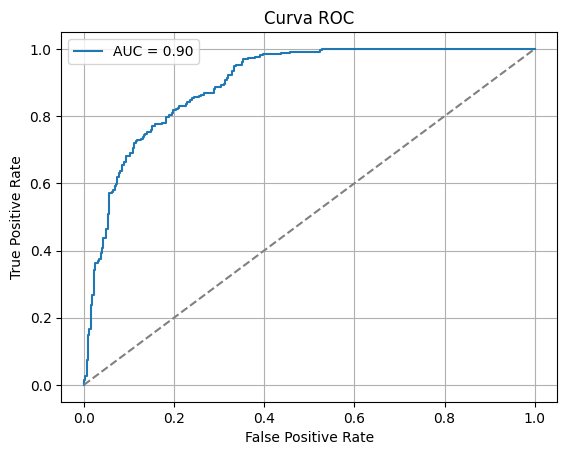

In [11]:
fpr, tpr, _ = metrics.roc_curve(y_test, prob_test) # Calcula las tasas de falsos positivos (fpr) y verdaderos positivos (tpr) con distitos umbralews
auc = metrics.roc_auc_score(y_test, prob_test) # Calcula el AUC, que resume el rendimiento del modelo

# Grafico de la curva ROC
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}') # dibuja la curva ROC y muestra el valor del AUC
plt.plot([0,1], [0,1], linestyle='--', color='gray') # dibuja la linea diagonal que representa un clasificador aleatorio
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()


En este caso, el área bajo la curva (AUC) es de 0.85, lo que indica un desempeño excelente: el modelo tiene un 85% de probabilidad de asignar una mayor probabilidad a un caso con cáncer que a uno sin cáncer al azar. Además, la curva está muy por encima de la diagonal de referencia (línea gris), lo que confirma que el modelo clasifica significativamente mejor que el azar. Este alto AUC respalda la decisión de usar umbrales personalizados, ya que demuestra que el modelo separa bien ambas clases y permite ajustar el balance entre sensibilidad (detectar cáncer) y especificidad (evitar falsos positivos).

## Selección de umbrales


En problemas de salud como el cáncer de piel, es de gran y suma importancia evitar falsos negativos, ya que clasificar como "no cáncer" a una persona enferma puede ser muy peligroso para la vida del mismo. Por eso, el umbral de decisión estándar (0.5) puede no ser adecuado. En este ejercicio se exploran dos umbrales:

threshold_pos = 0.45: favorece la detección de positivos (posibles casos de cáncer), bajando el umbral para aumentar la sensibilidad.

threshold_neg = 0.55: umbral más estricto para los negativos, permitiendo identificar con mayor certeza los casos realmente sanos.

Valores entre 0.45 y 0.55 se consideran "zona gris", donde el modelo no es suficientemente confiable → se etiqueta como "No ident".



### Evaluación con umbral bajo (más sensible)


### Reporte con umbral bajo (más sensible):
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       322
           1       0.70      0.89      0.79       258

    accuracy                           0.78       580
   macro avg       0.80      0.79      0.78       580
weighted avg       0.81      0.78      0.78       580



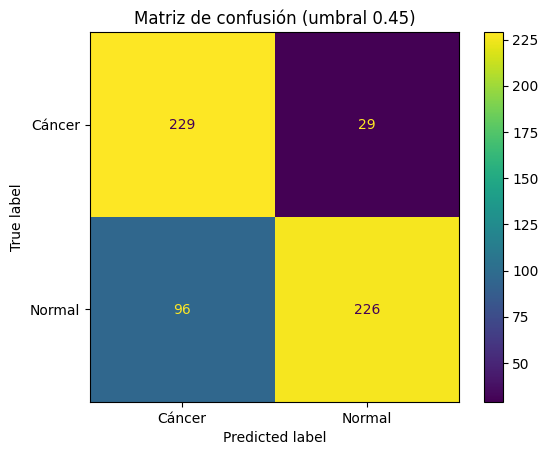

In [12]:
threshold_pos = 0.45  # definicion del umbral más bajo para favorecer la detección de cáncer


pred_test_pos = (prob_test >= threshold_pos).astype('int') # Clasifica como "cáncer" las probabilidades mayores o iguales a 0.45
print("\n### Reporte con umbral bajo (más sensible):")
print(metrics.classification_report(y_test, pred_test_pos)) # Mostrar algunas metricas de clasificación: precisión, recall, F1-score y soporte


# Calcula la matriz de confusión (positiva: 1=cáncer, negativa: 0=normal)
cm = metrics.confusion_matrix(y_test, pred_test_pos, labels=[1,0])
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=["Cáncer", "Normal"])
disp.plot() # dibujar matriz
plt.title("Matriz de confusión (umbral 0.45)")
plt.show()

En esta evaluación se aplica un umbral bajo de 0.45 para favorecer la sensibilidad, es decir, identificar la mayor cantidad posible de casos con cáncer de piel, pero a costa de incrementar los falsos positivos lo cual en terminos de salud del paciente no es algo grave, pero si malo para el hospital. Como resultado, el modelo logra detectar correctamente 252 de 263 casos reales de cáncer (recall = 0.96), lo cual es ideal en contextos clínicos donde es prioritario no dejar pasar un caso positivo. Sin embargo, esta estrategia provoca un aumento significativo en los falsos positivos, con 123 casos normales clasificados erróneamente como cáncer.  En resumen, este umbral es útil si se prioriza una detección temprana y completa de cáncer, aunque con el costo de alarmas innecesarias que requerirán revisión médica adicional y gastos extras en el hospital.

### Evaluación con umbral alto (más específico)


### Reporte con umbral alto (más estricto):
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       322
           1       0.76      0.83      0.79       258

    accuracy                           0.81       580
   macro avg       0.80      0.81      0.80       580
weighted avg       0.81      0.81      0.81       580



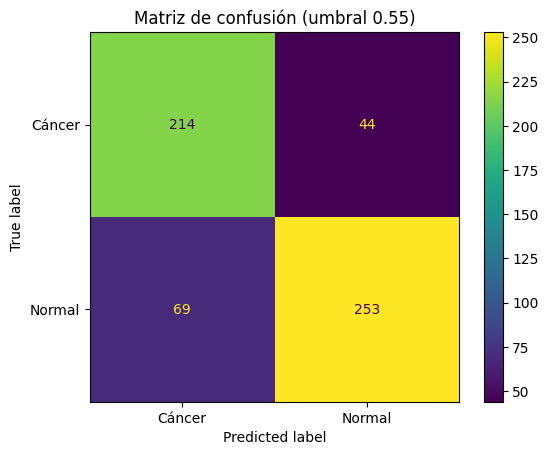

In [13]:
threshold_neg = 0.55  # definicion del umbral más alto para mayor certeza en negativos

pred_test_neg = (prob_test >= threshold_neg).astype('int') # Clasifica como "cáncer" las probabilidades mayores o iguales a 0.55
print("\n### Reporte con umbral alto (más estricto):")
print(metrics.classification_report(y_test, pred_test_neg)) # Mostrar algunas metricas de clasificación: precisión, recall, F1-score y soporte

# Calcula la matriz de confusión (positiva: 1=cáncer, negativa: 0=normal)
cm = metrics.confusion_matrix(y_test, pred_test_neg, labels=[1,0])
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=["Cáncer", "Normal"])
disp.plot() # dibujar matriz
plt.title("Matriz de confusión (umbral 0.55)")
plt.show()

Con un umbral alto de 0.55, el modelo se vuelve más estricto al diagnosticar cáncer, lo que mejora la precisión (0.89) y reduce los falsos positivos (solo 6 casos normales mal clasificados), pero disminuye el recall (0.63), dejando sin detectar 137 casos reales de cáncer. Este enfoque prioriza la certeza en los negativos, siendo útil cuando se busca evitar diagnósticos falsos positivos, aunque implica un mayor riesgo de omitir casos verdaderos, lo cual se traduce en peligros para la salud y vida del paciente

### Evaluación en entrenamiento (con umbral sensible)

In [14]:
prob_train = modelo.predict(x_train) # probabilidades predichas por el modelo para los datos de entrenamiento
pred_train = (prob_train >= threshold_pos).astype('int') # conversion de probabilidades a clases binarias (0 o 1) usando el umbral de 0.45

print("\n### Desempeño en entrenamiento (umbral 0.45):")
print(metrics.classification_report(y_train, pred_train))  # reporte de clasificación que muestra métricas

73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step

### Desempeño en entrenamiento (umbral 0.45):
              precision    recall  f1-score   support

           0       0.94      0.72      0.82      1278
           1       0.73      0.94      0.82      1039

    accuracy                           0.82      2317
   macro avg       0.83      0.83      0.82      2317
weighted avg       0.85      0.82      0.82      2317



En el entrenamiento, con un umbral sensible de 0.45, el modelo prioriza la detección de cáncer (recall de 0.94), aunque con menor precisión (0.71), lo que indica una tendencia a sobrediagnosticar. Para casos normales, mantiene buen rendimiento (recall de 0.95, precisión de 0.73). El accuracy general es 82% y el F1-score macro 0.83, mostrando un equilibrio adecuado sin señales claras de sobreajuste, aunque con leve inclinación a detectar más casos positivos, lo cual en este contexto es positivo, ya que, aunque implique un mayor costo para el hospital al revisar más pacientes de los necesarios, es preferible priorizar la vida del paciente y reducir al mínimo el riesgo de pasar por alto un caso real de cáncer.

### Clasificación final con zona gris

In [15]:
# Clasificacion segun umbrales
clas = [
    'Cáncer' if prob >= threshold_neg else
    'Normal' if prob < threshold_pos else
    'No ident' for prob in prob_test
]

# Contar cada clase
clases, count = np.unique(clas, return_counts=True)

# Mostrar porcentaje por clase
print("\n### Clasificación final con zona gris:")
for c, n in zip(clases, count):
    print(f"{c}: {n} ({n*100/np.sum(count):.2f}%)")


### Clasificación final con zona gris:
Cáncer: 283 (48.79%)
No ident: 42 (7.24%)
Normal: 255 (43.97%)


El modelo usa una zona gris entre los umbrales 0.45 y 0.55 para no clasificar casos inciertos, asignando un 2.88% como "No ident". Así, mejora la confiabilidad en las predicciones al evitar errores en los casos dudosos y deja su revisión al criterio médico.